# Tanzania Water Well Classification
### [Jeremy Pagirsky](https://github.com/jeremypagirsky)

## Project Scope and Objectives

This project seeks to examine the predictive factors underlying water well functionality in Tanzania. Like many African nations, Tanzania/Zanzibar have been subject to European colonization, resulting in political destabilization, poverty, hunger, and resource scarcity. 

One potential present-day impact of colonization is the dependency on colonizing nations with large sums of resources and capital (e.g., Germany, United Kingdom). Because of this, one of the main objectives is to examine the extent to which Tanzanian governmentally-funded vs externally-funded wells play a role in functionality.

## Imports and Data Collection

In [1]:
#standards
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
pd.options.display.max_rows=200

import missingno as msno

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
cd Data/

/Users/jerpagirsky/Desktop/Flatiron/CourseMaterials/Phase_3/Phase_3_Project/Data


In [3]:
df = pd.read_csv('Training_Data.csv')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

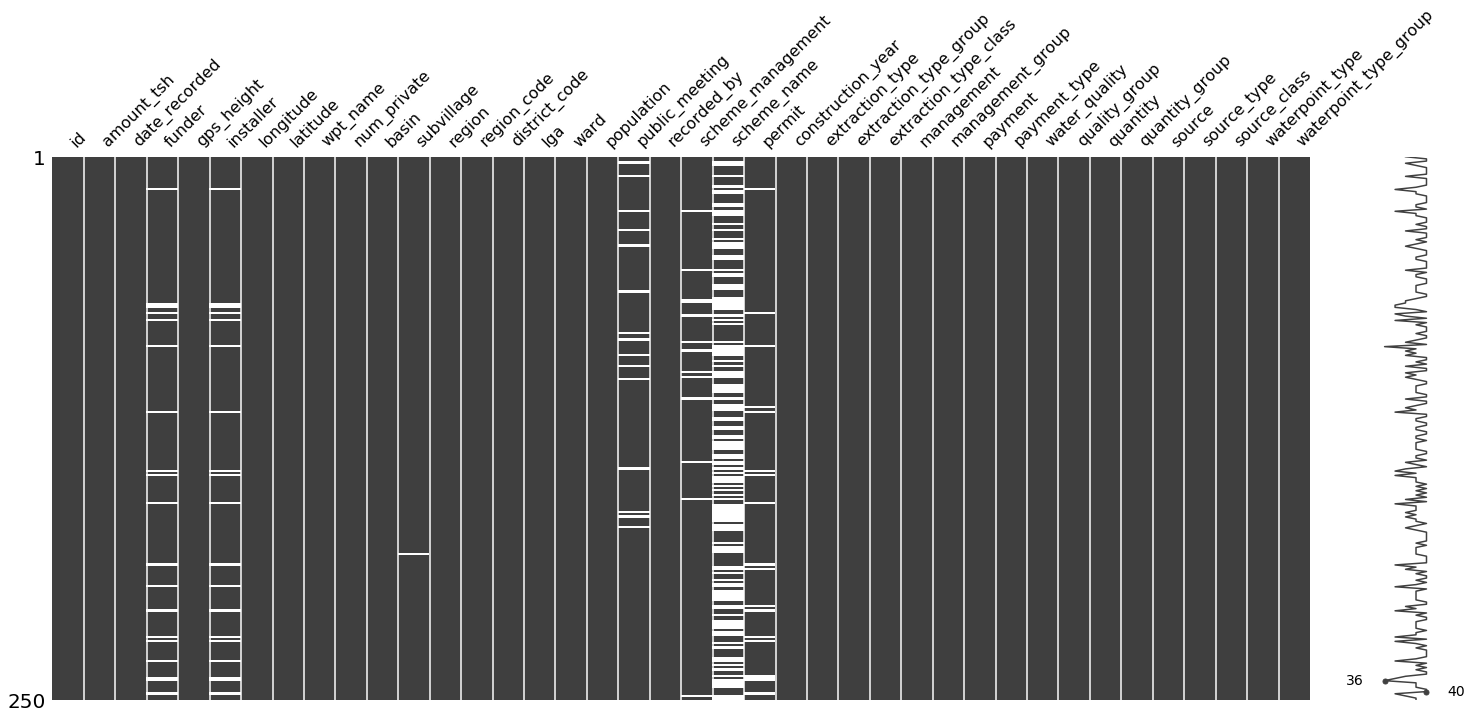

In [5]:
#explore missing data with missingno
msno.matrix(df.sample(250))

Both of these visuals show `funder` and `installer` to have missing data at practically the same places.

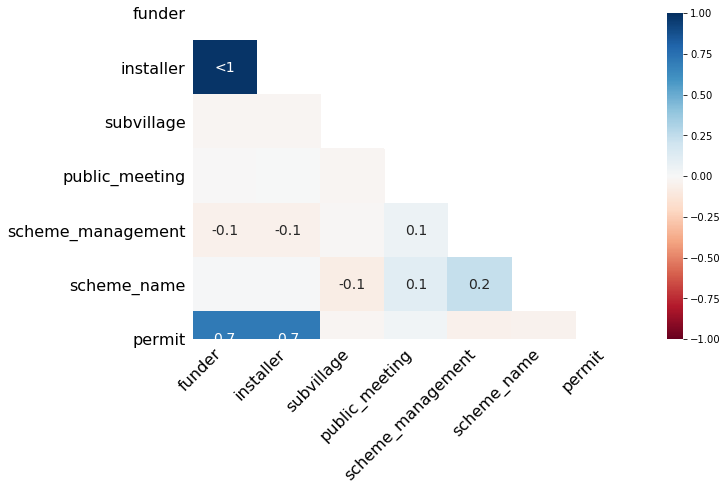

In [6]:
msno.heatmap(df, figsize=(10,6))

In [7]:
#data on target variable
target_df = pd.read_csv('Training_Set_Labels.csv')
target_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [9]:
#concatenate the target data to the original data
df = pd.concat([target_df['status_group'], df], axis=1)
df.head()

,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [10]:
df.describe(include='all')

,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55523,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,functional,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32259,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,NaN,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### Remove Unnecessary/Irrelevant Columns

This required some thought after combing through the data. I'll be dropping the columns below because they are not within the scope of this iteration of the project. It'll be less to navigate for preprocessing. Other reasons for dropping columns, such as `subvillage`, is to get rid of redundant columns that have too many categories. Additionally, I'll drop `construction_year` because it has too many missing values coded as 0. For future iterations of this project, I would like to research viable imputation methods for age.

In [11]:
len(df[df['construction_year']==0])/59400

0.34863636363636363

In [12]:
drop_cols = ['date_recorded', 'longitude', 'latitude',
             'wpt_name', 'num_private', 'subvillage', 'public_meeting', 'lga', 'ward', 
             'recorded_by', 'permit', 'scheme_name', 'construction_year', 'extraction_type',
            'management', 'payment', 'water_quality', 'quantity', 'installer']

In [13]:
df2 = df.drop(columns=drop_cols)
df2.head()

,status_group,id,amount_tsh,funder,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,69572,6000.0,Roman,1390,Lake Nyasa,Iringa,11,5,109,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,8776,0.0,Grumeti,1399,Lake Victoria,Mara,20,2,280,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,34310,25.0,Lottery Club,686,Pangani,Manyara,21,4,250,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,67743,0.0,Unicef,263,Ruvuma / Southern Coast,Mtwara,90,63,58,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,19728,0.0,Action In A,0,Lake Victoria,Kagera,18,1,0,NaN,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Remove Nulls and Duplicates

I want to see if there are any differences between Tanzanian government-funded and externally-funded waterpumps. I created a binary-indicator column to distinguish between the two.

In [14]:
#check duplicates on unique identifier
df2['id'].duplicated().sum()

0

In [15]:
df2.isna().sum()

status_group                0
id                          0
amount_tsh                  0
funder                   3635
gps_height                  0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
scheme_management        3877
extraction_type_group       0
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
dtype: int64

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
status_group             59400 non-null object
id                       59400 non-null int64
amount_tsh               59400 non-null float64
funder                   55765 non-null object
gps_height               59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
population               59400 non-null int64
scheme_management        55523 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management_group         59400 non-null object
payment_type             59400 non-null object
quality_group            59400 non-null object
quantity_group           59400 non-null object
source                   59400 non-null object
source_type              59400 non-null object
so

In [17]:
#'constant'
impute = SimpleImputer(strategy='constant', fill_value='unknown')

In [18]:
impute_cols = ['funder', 'scheme_management']

In [19]:
df2[impute_cols] = impute.fit_transform(df[impute_cols])

In [20]:
df2.isna().sum()

status_group             0
id                       0
amount_tsh               0
funder                   0
gps_height               0
basin                    0
region                   0
region_code              0
district_code            0
population               0
scheme_management        0
extraction_type_group    0
extraction_type_class    0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [21]:
df2.head()

,status_group,id,amount_tsh,funder,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,69572,6000.0,Roman,1390,Lake Nyasa,Iringa,11,5,109,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,8776,0.0,Grumeti,1399,Lake Victoria,Mara,20,2,280,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,34310,25.0,Lottery Club,686,Pangani,Manyara,21,4,250,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,67743,0.0,Unicef,263,Ruvuma / Southern Coast,Mtwara,90,63,58,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,19728,0.0,Action In A,0,Lake Victoria,Kagera,18,1,0,unknown,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [22]:
df2.describe(include='all')

,status_group,id,amount_tsh,funder,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,59400.000000,59400.000000,59400,59400.000000,59400,59400,59400.000000,59400.000000,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,NaN,NaN,1898,NaN,9,21,NaN,NaN,NaN,13,13,7,5,7,6,5,10,7,3,7,6
top,functional,NaN,NaN,Government Of Tanzania,NaN,Lake Victoria,Iringa,NaN,NaN,NaN,VWC,gravity,gravity,user-group,never pay,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32259,NaN,NaN,9084,NaN,10248,5294,NaN,NaN,NaN,36793,26780,26780,52490,25348,50818,33186,17021,17021,45794,28522,34625
mean,NaN,37115.131768,317.650385,NaN,668.297239,NaN,NaN,15.297003,5.629747,179.909983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,21453.128371,2997.574558,NaN,693.116350,NaN,NaN,17.587406,9.633649,471.482176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,NaN,-90.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,18519.750000,0.000000,NaN,0.000000,NaN,NaN,5.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,37061.500000,0.000000,NaN,369.000000,NaN,NaN,12.000000,3.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,55656.500000,20.000000,NaN,1319.250000,NaN,NaN,17.000000,5.000000,215.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
status_group             59400 non-null object
id                       59400 non-null int64
amount_tsh               59400 non-null float64
funder                   59400 non-null object
gps_height               59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
population               59400 non-null int64
scheme_management        59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management_group         59400 non-null object
payment_type             59400 non-null object
quality_group            59400 non-null object
quantity_group           59400 non-null object
source                   59400 non-null object
source_type              59400 non-null object
so

I will look at the top 20 most frequent values for `funder` and `installer` and select government entities.

In [24]:
(df2['funder'].value_counts(normalize=True)*100).head(20)

Government Of Tanzania    15.292929
unknown                    6.119529
Danida                     5.242424
Hesawa                     3.707071
Rwssp                      2.313131
World Bank                 2.271044
Kkkt                       2.166667
World Vision               2.097643
Unicef                     1.779461
Tasaf                      1.476431
District Council           1.419192
Dhv                        1.395623
Private Individual         1.390572
Dwsp                       1.365320
0                          1.308081
Norad                      1.287879
Germany Republi            1.026936
Tcrs                       1.013468
Ministry Of Water          0.993266
Water                      0.981481
Name: funder, dtype: float64

In [25]:
#government funders column
#grouping together all Tanzanian government entities from above
#write as string so it can get encoded along with other predictors
df2['govt_fund'] = df2['funder'].apply(lambda x:'govt' if x=='Government Of Tanzania' 
                                       or x=='Rwssp' or x=='Tasaf' or x=='District Council' or x=='Ministry Of Water'
                                       or x=='Water' else 'non_govt')

In [26]:
#amt per class
print((df2['govt_fund'].value_counts(normalize=True)*100).head(10))

non_govt    77.523569
govt        22.476431
Name: govt_fund, dtype: float64


In [27]:
df2 = df2.drop(columns = ['funder'])
df2.head()

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
0,functional,69572,6000.0,1390,Lake Nyasa,Iringa,11,5,109,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
1,functional,8776,0.0,1399,Lake Victoria,Mara,20,2,280,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt
2,functional,34310,25.0,686,Pangani,Manyara,21,4,250,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,non_govt
3,non functional,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,90,63,58,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non_govt
4,functional,19728,0.0,0,Lake Victoria,Kagera,18,1,0,unknown,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt


In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
status_group             59400 non-null object
id                       59400 non-null int64
amount_tsh               59400 non-null float64
gps_height               59400 non-null int64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
population               59400 non-null int64
scheme_management        59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management_group         59400 non-null object
payment_type             59400 non-null object
quality_group            59400 non-null object
quantity_group           59400 non-null object
source                   59400 non-null object
source_type              59400 non-null object
source_class             59400 non-null object
wa

### Outliers

In [29]:
df2.describe(include='all')

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
count,59400,59400.000000,59400.000000,59400.000000,59400,59400,59400.000000,59400.000000,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,NaN,NaN,NaN,9,21,NaN,NaN,NaN,13,13,7,5,7,6,5,10,7,3,7,6,2
top,functional,NaN,NaN,NaN,Lake Victoria,Iringa,NaN,NaN,NaN,VWC,gravity,gravity,user-group,never pay,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
freq,32259,NaN,NaN,NaN,10248,5294,NaN,NaN,NaN,36793,26780,26780,52490,25348,50818,33186,17021,17021,45794,28522,34625,46049
mean,NaN,37115.131768,317.650385,668.297239,NaN,NaN,15.297003,5.629747,179.909983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,21453.128371,2997.574558,693.116350,NaN,NaN,17.587406,9.633649,471.482176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-90.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,18519.750000,0.000000,0.000000,NaN,NaN,5.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,37061.500000,0.000000,369.000000,NaN,NaN,12.000000,3.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,55656.500000,20.000000,1319.250000,NaN,NaN,17.000000,5.000000,215.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df2 = df2[((df2['id'] != 0) & (df2['district_code'] != 0) & (df2['region_code'] < 99))]
df2

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
0,functional,69572,6000.0,1390,Lake Nyasa,Iringa,11,5,109,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
1,functional,8776,0.0,1399,Lake Victoria,Mara,20,2,280,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt
2,functional,34310,25.0,686,Pangani,Manyara,21,4,250,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,non_govt
3,non functional,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,90,63,58,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non_govt
4,functional,19728,0.0,0,Lake Victoria,Kagera,18,1,0,unknown,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,functional,60739,10.0,1210,Pangani,Kilimanjaro,3,5,125,Water Board,gravity,gravity,user-group,per bucket,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
59396,functional,27263,4700.0,1212,Rufiji,Iringa,11,4,56,VWC,gravity,gravity,user-group,annually,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,non_govt
59397,functional,37057,0.0,0,Rufiji,Mbeya,12,7,0,VWC,swn 80,handpump,user-group,monthly,fluoride,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non_govt
59398,functional,31282,0.0,0,Rufiji,Dodoma,1,4,0,VWC,nira/tanira,handpump,user-group,never pay,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non_govt


### Normalize Continuous Data

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58953 entries, 0 to 59399
Data columns (total 22 columns):
status_group             58953 non-null object
id                       58953 non-null int64
amount_tsh               58953 non-null float64
gps_height               58953 non-null int64
basin                    58953 non-null object
region                   58953 non-null object
region_code              58953 non-null int64
district_code            58953 non-null int64
population               58953 non-null int64
scheme_management        58953 non-null object
extraction_type_group    58953 non-null object
extraction_type_class    58953 non-null object
management_group         58953 non-null object
payment_type             58953 non-null object
quality_group            58953 non-null object
quantity_group           58953 non-null object
source                   58953 non-null object
source_type              58953 non-null object
source_class             58953 non-null object
wa

In [32]:
cont_cols = [c for c in df2 if df2[c].dtype == 'int' or df2[c].dtype == 'float' if c not in 'id']
cont_cols

['amount_tsh', 'gps_height', 'region_code', 'district_code', 'population']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c992d1e10>,
      dtype=object)

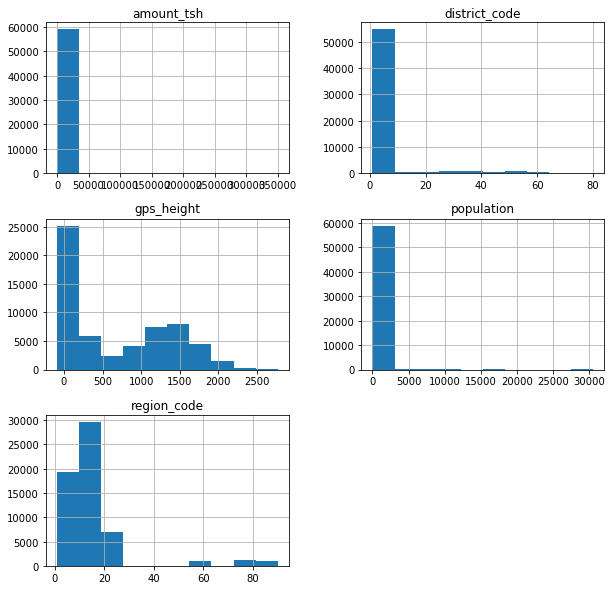

In [33]:
pre_norm_hist = df2[cont_cols].hist(figsize=(10,10))
pre_norm_hist

In [34]:
norm = Normalizer(norm='l2')

In [35]:
df2[cont_cols] = norm.fit_transform(df2[cont_cols])
df2[cont_cols]

,amount_tsh,gps_height,region_code,district_code,population
0,0.974045,0.225654,0.001786,0.000812,0.017695
1,0.000000,0.980456,0.014017,0.001402,0.196231
2,0.034206,0.938601,0.028733,0.005473,0.342056
3,0.000000,0.904202,0.309423,0.216596,0.199406
4,0.000000,0.000000,0.998460,0.055470,0.000000
...,...,...,...,...,...
59395,0.008220,0.994661,0.002466,0.004110,0.102754
59396,0.968255,0.249686,0.002266,0.000824,0.011537
59397,0.000000,0.000000,0.863779,0.503871,0.000000
59398,0.000000,0.000000,0.242536,0.970143,0.000000


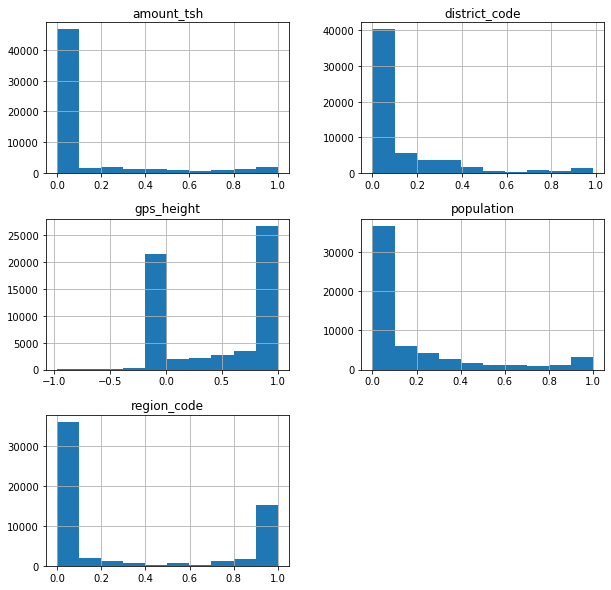

In [36]:
post_norm_hist = df2[cont_cols].hist(figsize=(10,10))

### Data Encoding

I used scikit-learn's LabelEncoder to encode the target data and I used the OrdinalEncoder for the predictors.

(array([32064.,     0.,     0.,     0.,     0., 22581.,     0.,     0.,
            0.,  4308.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

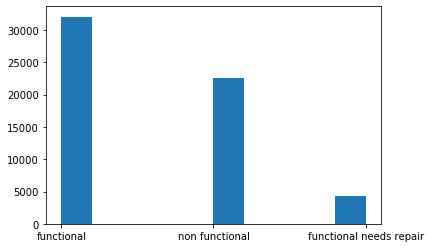

In [37]:
plt.hist(df2['status_group'])

In [38]:
le = LabelEncoder()
df2['status_group'] = le.fit_transform(df2['status_group'])
df2.head()

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
0,0,69572,0.974045,0.225654,Lake Nyasa,Iringa,0.001786,0.000812,0.017695,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
1,0,8776,0.000000,0.980456,Lake Victoria,Mara,0.014017,0.001402,0.196231,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt
2,0,34310,0.034206,0.938601,Pangani,Manyara,0.028733,0.005473,0.342056,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,non_govt
3,2,67743,0.000000,0.904202,Ruvuma / Southern Coast,Mtwara,0.309423,0.216596,0.199406,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non_govt
4,0,19728,0.000000,0.000000,Lake Victoria,Kagera,0.998460,0.055470,0.000000,unknown,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt


(array([32064.,     0.,     0.,     0.,     0.,  4308.,     0.,     0.,
            0., 22581.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

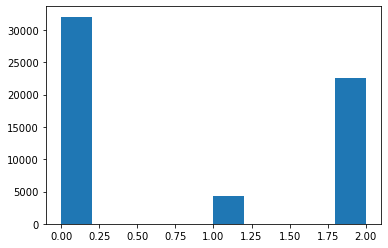

In [39]:
#plot which 
plt.hist(df2['status_group'])

In [40]:
#change region_code and district_code to string to do Ordinal Encoding

df2[['region_code', 'district_code']] = df2[['region_code', 'district_code']].astype(str)
df2.head()

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
0,0,69572,0.974045,0.225654,Lake Nyasa,Iringa,0.0017857489463037305,0.0008117040665016956,0.017695,VWC,gravity,gravity,user-group,annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non_govt
1,0,8776,0.000000,0.980456,Lake Victoria,Mara,0.014016532087166233,0.001401653208716623,0.196231,Other,gravity,gravity,user-group,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt
2,0,34310,0.034206,0.938601,Pangani,Manyara,0.028732690571195384,0.005472893442132454,0.342056,VWC,gravity,gravity,user-group,per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,non_govt
3,2,67743,0.000000,0.904202,Ruvuma / Southern Coast,Mtwara,0.3094227164203366,0.21659590149423563,0.199406,VWC,submersible,submersible,user-group,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non_govt
4,0,19728,0.000000,0.000000,Lake Victoria,Kagera,0.9984603532054125,0.05547001962252291,0.000000,unknown,gravity,gravity,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non_govt


In [41]:
enc_cols = [c for c in df2 if df2[c].dtype == 'object']
enc_cols

['basin',
 'region',
 'region_code',
 'district_code',
 'scheme_management',
 'extraction_type_group',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'govt_fund']

In [42]:
#encoded dataframe
oc = OrdinalEncoder()
df2[enc_cols] = oc.fit_transform(df2[enc_cols])
df2.head()

,status_group,id,amount_tsh,gps_height,basin,region,region_code,district_code,population,scheme_management,extraction_type_group,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,govt_fund
0,0,69572,0.974045,0.225654,1.0,3.0,3009.0,5175.0,0.017695,7.0,1.0,0.0,4.0,0.0,2.0,1.0,8.0,6.0,0.0,1.0,1.0,1.0
1,0,8776,0.000000,0.980456,4.0,9.0,26067.0,10674.0,0.196231,2.0,1.0,0.0,4.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0,1.0
2,0,34310,0.034206,0.938601,5.0,8.0,31165.0,26579.0,0.342056,7.0,1.0,0.0,4.0,5.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0
3,2,67743,0.000000,0.904202,7.0,12.0,34773.0,34946.0,0.199406,7.0,10.0,5.0,4.0,2.0,2.0,0.0,3.0,0.0,0.0,2.0,1.0,1.0
4,0,19728,0.000000,0.000000,4.0,4.0,35552.0,33192.0,0.000000,12.0,1.0,0.0,1.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0


### Multicollinearity

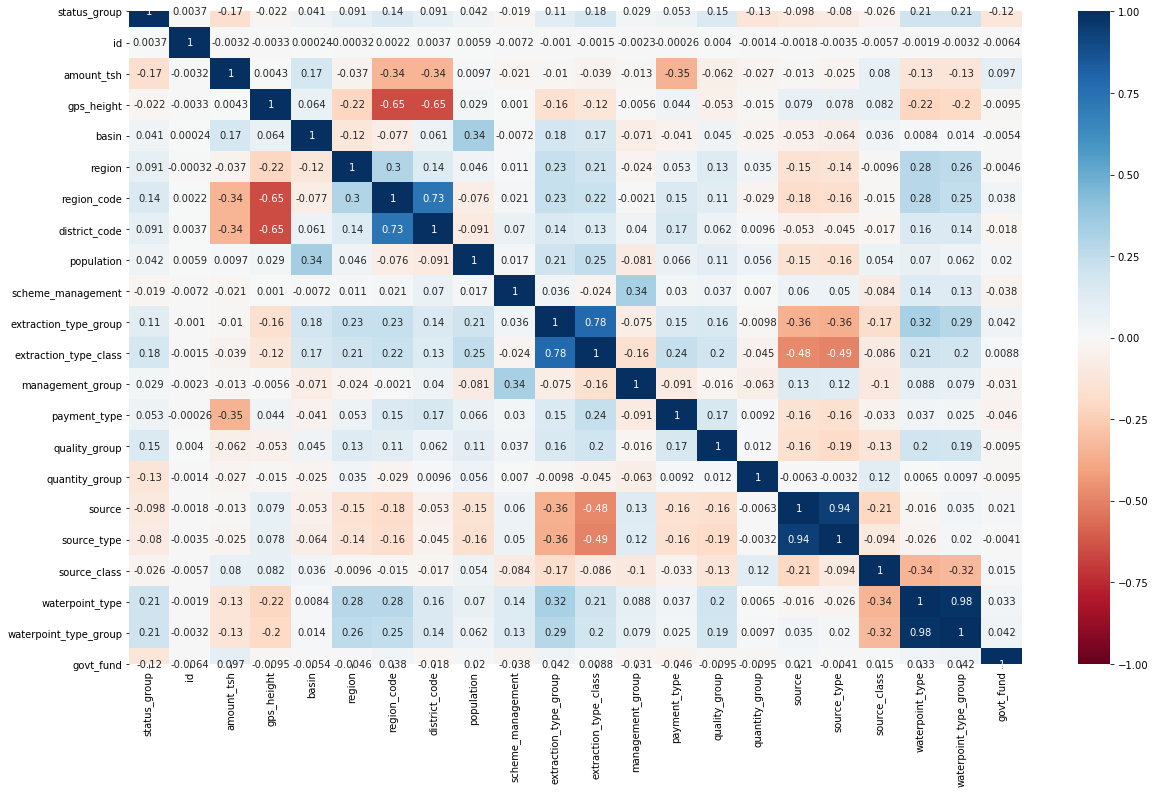

In [43]:
plt.figure(figsize=(20,12))
sns.heatmap(df2.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)

`extraction_type_group` and `extraction_type_class` are highly correlated with each other, along with `source` and `source_type`, `waterpoint_type` and `waterpoint_type_group`, `basin` and `region_code`, and `govt_fund` and `govt_install`. Because these correlates are fairly redundant, I will keep the columns that have fewer categories.

In [44]:
val_ct_cols = ['extraction_type_group', 'extraction_type_class', 'source', 'source_type',
              'waterpoint_type', 'waterpoint_type_group', 'basin', 'region_code', 'govt_fund']

for col in df2[val_ct_cols]:
    print(df2[col].value_counts())

1.0     26770
5.0      8128
6.0      6351
10.0     5990
11.0     3669
4.0      2757
2.0      2367
0.0      1769
9.0       451
7.0       364
8.0       122
12.0      117
3.0        98
Name: extraction_type_group, dtype: int64
0.0    26770
1.0    16395
3.0     6351
5.0     5990
2.0     2879
4.0      451
6.0      117
Name: extraction_type_class, dtype: int64
8.0    17007
7.0    16745
3.0    10726
6.0     9612
5.0     2290
1.0      874
2.0      765
0.0      656
4.0      212
9.0       66
Name: source, dtype: int64
6.0    17007
5.0    16745
0.0    11600
4.0    10377
3.0     2290
1.0      656
2.0      278
Name: source_type, dtype: int64
1.0    28481
4.0    17427
6.0     6303
2.0     5835
5.0      784
0.0      116
3.0        7
Name: waterpoint_type, dtype: int64
1.0    34316
3.0    17427
5.0     6303
4.0      784
0.0      116
2.0        7
Name: waterpoint_type_group, dtype: int64
4.0    10248
5.0     8940
6.0     7976
0.0     7785
3.0     6431
8.0     5964
1.0     5085
7.0     4070
2.0     2454

In [45]:
#new dataframe for model
df3 = df2.drop(columns=['extraction_type_group', 'source', 'waterpoint_type', 'region_code'])
df3.head()

,status_group,id,amount_tsh,gps_height,basin,region,district_code,population,scheme_management,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,govt_fund
0,0,69572,0.974045,0.225654,1.0,3.0,5175.0,0.017695,7.0,0.0,4.0,0.0,2.0,1.0,6.0,0.0,1.0,1.0
1,0,8776,0.000000,0.980456,4.0,9.0,10674.0,0.196231,2.0,0.0,4.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0
2,0,34310,0.034206,0.938601,5.0,8.0,26579.0,0.342056,7.0,0.0,4.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0
3,2,67743,0.000000,0.904202,7.0,12.0,34946.0,0.199406,7.0,5.0,4.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
4,0,19728,0.000000,0.000000,4.0,4.0,33192.0,0.000000,12.0,0.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0


In [46]:
df3 = df3.set_index('id')
df3.head()

,status_group,amount_tsh,gps_height,basin,region,district_code,population,scheme_management,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,govt_fund
id,,,,,,,,,,,,,,,,,
69572,0,0.974045,0.225654,1.0,3.0,5175.0,0.017695,7.0,0.0,4.0,0.0,2.0,1.0,6.0,0.0,1.0,1.0
8776,0,0.000000,0.980456,4.0,9.0,10674.0,0.196231,2.0,0.0,4.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0
34310,0,0.034206,0.938601,5.0,8.0,26579.0,0.342056,7.0,0.0,4.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0
67743,2,0.000000,0.904202,7.0,12.0,34946.0,0.199406,7.0,5.0,4.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
19728,0,0.000000,0.000000,4.0,4.0,33192.0,0.000000,12.0,0.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0


## Baseline Models

### Scale and Train-Test Split Data

In [47]:
scaler=StandardScaler()

X_cols = [c for c in df3.columns if c not in 'status_group']

X = df3[X_cols]
y = df3['status_group']

#scale data
X_scaled = scaler.fit_transform(X)

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=42)

### Model Functions

In [48]:
def eval_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
        
    print('Train Scores:')
    print(f"Accuracy: {accuracy_score(y_train, train_preds):.3f}")
    print(f"Recall Score: {recall_score(y_train, train_preds, average='micro'):.3f}")
    print(f"Precision Score: {precision_score(y_train, train_preds, average='micro'):.3f}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average='micro'):.3f}")
    
    #I used micro-averaging, as it is useful for class imbalance in a multi-class target variable.
    
    print('\n')
    
    print('Test Scores:')
    print(f"Accuracy: {accuracy_score(y_test, test_preds):.3f}")
    print(f"Recall Score: {recall_score(y_test, test_preds, average='micro'):.3f}")
    print(f"Precision Score: {precision_score(y_test, test_preds, average='micro'):.3f}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average='micro'):.3f}")

**Source code:** Lindsey Berlin

In [49]:
#feature selection

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

**Source code:** [Catherine Wolk](https://github.com/cwolk1992/PopularIndieRock/blob/master/Spotify%20Analysis%20Final.ipynb)

In [50]:
#confusion matrix function
def confusion_matrix(model, X_test, y_test):
    plot_confusion_matrix(model, X_test, y_test, cmap='viridis',values_format=".3g")
    plt.grid(False) 
    plt.show()

### Logistic Regression

Train Scores:
Accuracy: 0.641
Recall Score: 0.641
Precision Score: 0.641
F1 Score: 0.641


Test Scores:
Accuracy: 0.639
Recall Score: 0.639
Precision Score: 0.639
F1 Score: 0.639


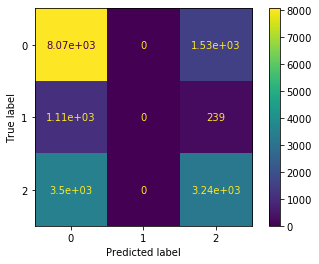

In [51]:
log_reg=LogisticRegression()
eval_model(log_reg, X_train, X_test, y_train, y_test)
confusion_matrix(log_reg, X_test, y_test)

### Tree-Based Model – Decision Tree Classifier

Train Scores:
Accuracy: 0.715
Recall Score: 0.715
Precision Score: 0.715
F1 Score: 0.715


Test Scores:
Accuracy: 0.709
Recall Score: 0.709
Precision Score: 0.709
F1 Score: 0.709


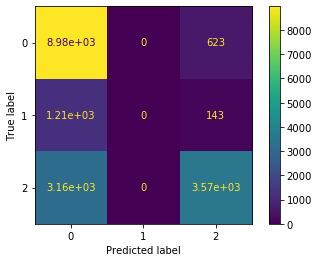

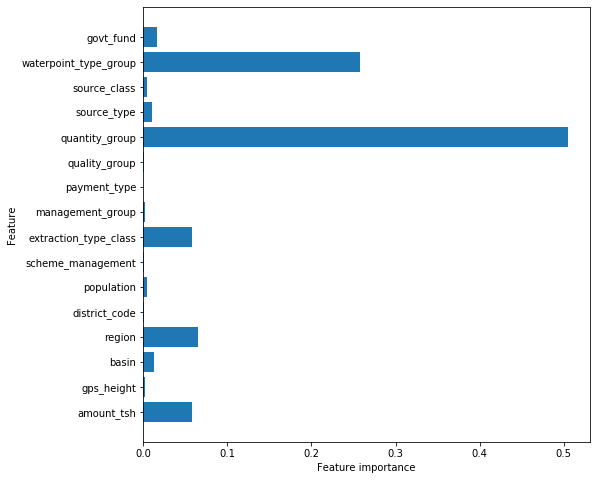

In [52]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)

eval_model(tree, X_train, X_test, y_train, y_test)
confusion_matrix(tree, X_test, y_test)
plot_feature_importances(tree)

### Ensemble Method – Random Forest Classifier

Train Scores:
Accuracy: 0.938
Recall Score: 0.938
Precision Score: 0.938
F1 Score: 0.938


Test Scores:
Accuracy: 0.768
Recall Score: 0.768
Precision Score: 0.768
F1 Score: 0.768


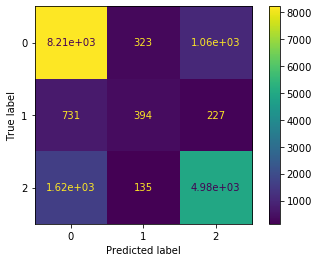

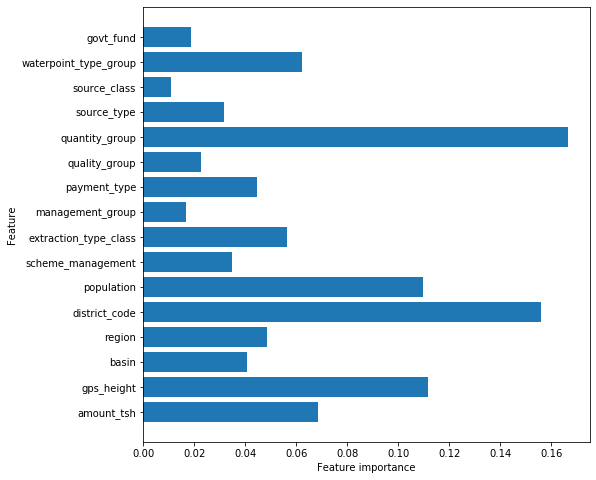

In [53]:
rf = RandomForestClassifier()
eval_model(rf, X_train, X_test, y_train, y_test)
confusion_matrix(rf, X_test, y_test)
plot_feature_importances(rf)

### XGBoost

Train Scores:
Accuracy: 0.695
Recall Score: 0.695
Precision Score: 0.695
F1 Score: 0.695


Test Scores:
Accuracy: 0.692
Recall Score: 0.692
Precision Score: 0.692
F1 Score: 0.692


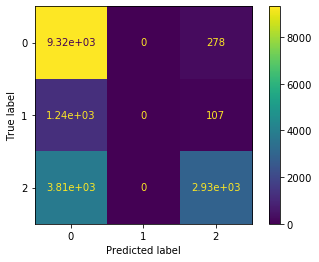

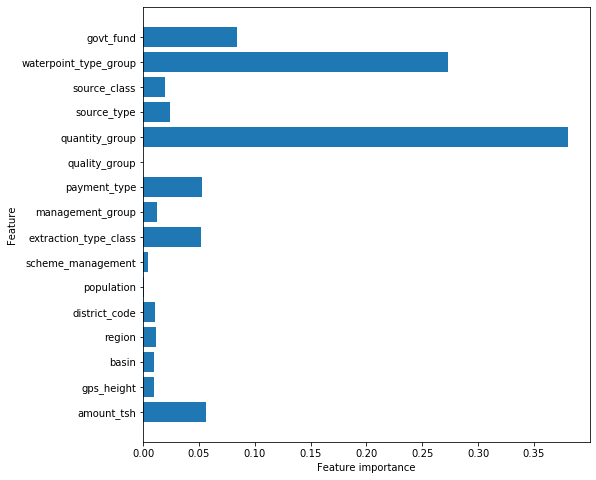

In [54]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

eval_model(xgb_model, X_train, X_test, y_train, y_test)
confusion_matrix(xgb_model, X_test, y_test)
plot_feature_importances(xgb_model)

### Model Type Selection

After testing and comparing three different models, I am most confident in selecting the **Random Forest Classifier** as my model type. The scoring metrics are all much higher than the prior two models. Based on the confusion matrices, the Random Forest was able to return higher proportions of true positives/negatives compared to false ones. While this model is evidently overfit, I believe, based on the "kitchen-sink" strategy, this is a more easily manageable drawback compared to the aforementioned benefits. Perhaps removing some features will be able to elicit clearer feature importances and selection.

## Model Tuning

In [55]:
rf2 = RandomForestClassifier(criterion='gini', bootstrap=True, class_weight='balanced')

Train Scores:
Accuracy: 0.919
Recall Score: 0.919
Precision Score: 0.919
F1 Score: 0.919


Test Scores:
Accuracy: 0.752
Recall Score: 0.752
Precision Score: 0.752
F1 Score: 0.752


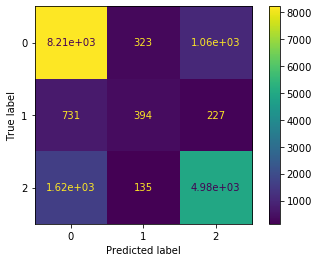

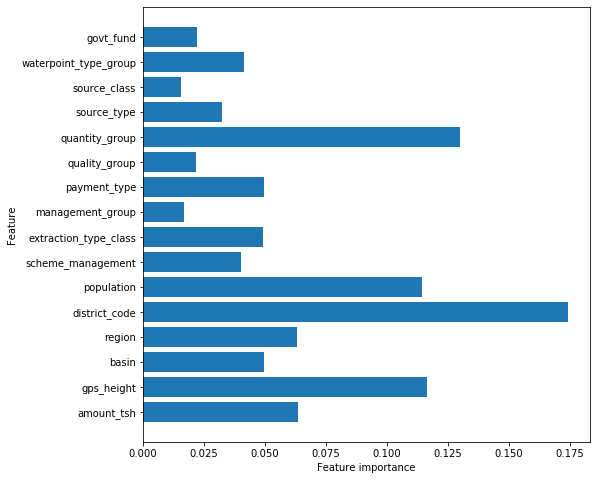

In [56]:
eval_model(rf2, X_train, X_test, y_train, y_test)
confusion_matrix(rf, X_test, y_test)
plot_feature_importances(rf2)

This model depicts a well's district location, amount of water it contains, the type of water well, and its surrounding population to be important features in predicting functionality. However, it is still overfit. I am going to explore which features to remove to prevent overfitting.

In [57]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58953 entries, 69572 to 26348
Data columns (total 17 columns):
status_group             58953 non-null int64
amount_tsh               58953 non-null float64
gps_height               58953 non-null float64
basin                    58953 non-null float64
region                   58953 non-null float64
district_code            58953 non-null float64
population               58953 non-null float64
scheme_management        58953 non-null float64
extraction_type_class    58953 non-null float64
management_group         58953 non-null float64
payment_type             58953 non-null float64
quality_group            58953 non-null float64
quantity_group           58953 non-null float64
source_type              58953 non-null float64
source_class             58953 non-null float64
waterpoint_type_group    58953 non-null float64
govt_fund                58953 non-null float64
dtypes: float64(16), int64(1)
memory usage: 8.1 MB


I am going to remove some redundant and/or less important features in order to help with overfitting. While `govt_fund` is not an important feature in this model, I am curious to see if removing other features will increase its relative importance.

In [58]:
df4 = df3.drop(columns=['source_class',  'quality_group', 'management_group', 'basin'])
df.head()

,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,functional,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,functional,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,functional,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,non functional,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,functional,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [59]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58953 entries, 69572 to 26348
Data columns (total 13 columns):
status_group             58953 non-null int64
amount_tsh               58953 non-null float64
gps_height               58953 non-null float64
region                   58953 non-null float64
district_code            58953 non-null float64
population               58953 non-null float64
scheme_management        58953 non-null float64
extraction_type_class    58953 non-null float64
payment_type             58953 non-null float64
quantity_group           58953 non-null float64
source_type              58953 non-null float64
waterpoint_type_group    58953 non-null float64
govt_fund                58953 non-null float64
dtypes: float64(12), int64(1)
memory usage: 6.3 MB


In [60]:
#redefine X and y
X_cols = [c for c in df4.columns if c not in 'status_group']

X = df4[X_cols]
y = df4['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Train Scores:
Accuracy: 0.912
Recall Score: 0.912
Precision Score: 0.912
F1 Score: 0.912


Test Scores:
Accuracy: 0.748
Recall Score: 0.748
Precision Score: 0.748
F1 Score: 0.748


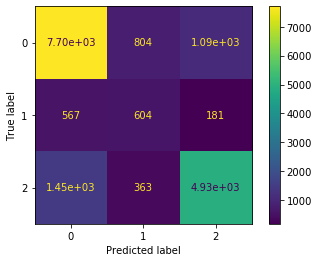

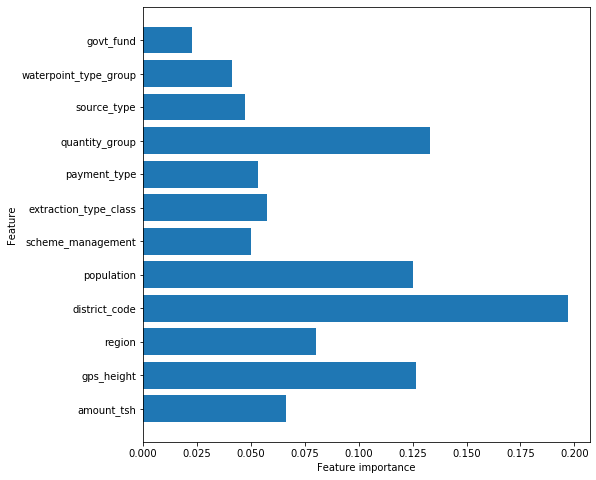

In [61]:
eval_model(rf2, X_train, X_test, y_train, y_test)
confusion_matrix(rf2, X_test, y_test)
plot_feature_importances(rf2)

The model is still overfit. I am going to change some hyperparameters to see if it will make a difference.

Train Scores:
Accuracy: 0.745
Recall Score: 0.745
Precision Score: 0.745
F1 Score: 0.745


Test Scores:
Accuracy: 0.734
Recall Score: 0.734
Precision Score: 0.734
F1 Score: 0.734


Train Confusion Matrix:


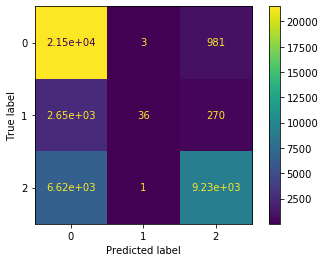

Test Confusion Matrix:


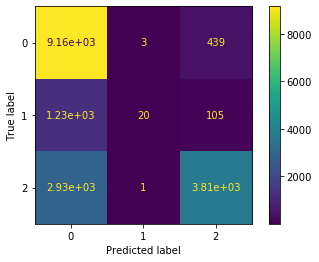

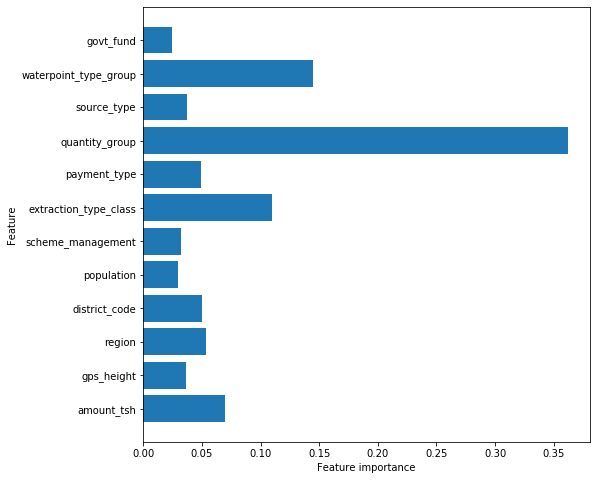

In [62]:
rf3 = RandomForestClassifier(n_estimators=200, max_depth=9, min_samples_split=2)
eval_model(rf3, X_train, X_test, y_train, y_test)
print('\n')
print('Train Confusion Matrix:')
confusion_matrix(rf3, X_train, y_train)

print('Test Confusion Matrix:')
confusion_matrix(rf3, X_test, y_test)

plot_feature_importances(rf3)

This model is much less overfit, but can perhaps be stripped of less important features. Because `govt_fund` is a variable of primary focus, I will keep it.

In [63]:
df5 = df4.drop(columns=['source_type', 'payment_type', 'scheme_management',
                        'population', 'district_code', 'gps_height', ])
df5.head()

,status_group,amount_tsh,region,extraction_type_class,quantity_group,waterpoint_type_group,govt_fund
id,,,,,,,
69572,0,0.974045,3.0,0.0,1.0,1.0,1.0
8776,0,0.000000,9.0,0.0,2.0,1.0,1.0
34310,0,0.034206,8.0,0.0,1.0,1.0,1.0
67743,2,0.000000,12.0,5.0,0.0,1.0,1.0
19728,0,0.000000,4.0,0.0,3.0,1.0,1.0


In [64]:
df5.head()

,status_group,amount_tsh,region,extraction_type_class,quantity_group,waterpoint_type_group,govt_fund
id,,,,,,,
69572,0,0.974045,3.0,0.0,1.0,1.0,1.0
8776,0,0.000000,9.0,0.0,2.0,1.0,1.0
34310,0,0.034206,8.0,0.0,1.0,1.0,1.0
67743,2,0.000000,12.0,5.0,0.0,1.0,1.0
19728,0,0.000000,4.0,0.0,3.0,1.0,1.0


In [65]:
X_cols = [c for c in df5.columns if c not in 'status_group']

X = df5[X_cols]
y = df5['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Train Scores:
Accuracy: 0.731
Recall Score: 0.731
Precision Score: 0.731
F1 Score: 0.731


Test Scores:
Accuracy: 0.724
Recall Score: 0.724
Precision Score: 0.724
F1 Score: 0.724


Train Confusion Matrix:


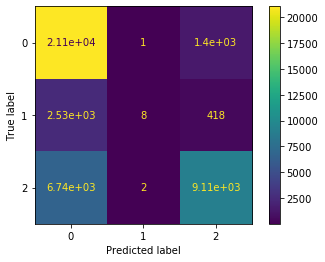

Test Confusion Matrix:


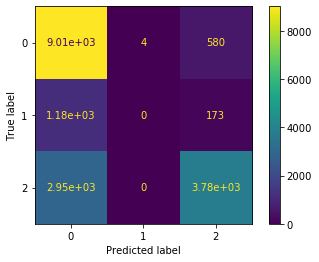

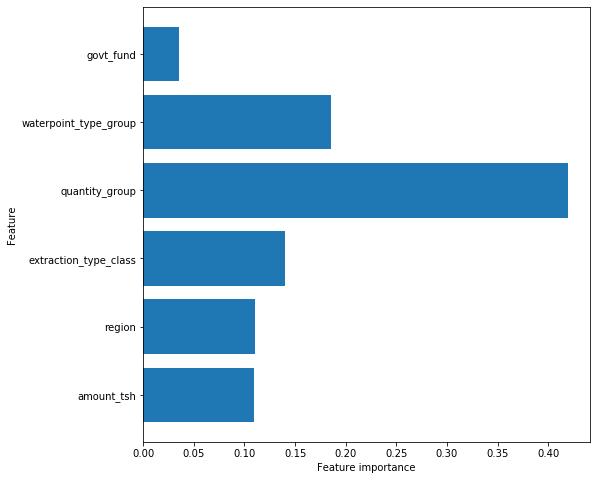

In [66]:
rf4 = RandomForestClassifier(n_estimators=200, max_depth=9, min_samples_split=2)
eval_model(rf4, X_train, X_test, y_train, y_test)
print('\n')
print('Train Confusion Matrix:')
confusion_matrix(rf4, X_train, y_train)

print('Test Confusion Matrix:')
confusion_matrix(rf4, X_test, y_test)

plot_feature_importances(rf4)

## Results

The fourth iteration of the Random Forest Classifier model is 72.4% accurate in classifying water well functionality. The prior iteration is 73.4% accurate in its predictions. While the model performs quite well in accurately predicting functional water wells, it has difficulty in accurately predicting non-functional water wells and wells that are functional but need repair. Specifically, it predicts a well to be fully functional when it actually either needs repair or is not functional.

I displayed recall, precision, and F1 scores for further information. However, because of the micro-averaging techniques used in scoring, all values are given equal weight and, therefore, are identical. With that in mind, the primary metric for this project is accuracy. While it is evident that false negatives play a major role in the model, these metrics are heavily influenced by micro-averaging techniques. I believe the model's accuracy is encompassing of the multi-class nature of the model without being heavily influenced by averaging techniques. Perhaps most importantly, it is informative of the model's capability to classify the target.

Both models present `quantity_group`, `waterpoint_type_group`, and `extraction_type_class` as important features in predicting functionality.`govt_fund` was the least important feature in both models, rejecting the alternate hypothesis. In the end, I would choose the model with 73.4% accuracy.

## Limitations

As previously mentioned, a major limitation of the model is its tendency to predict non-functional water wells or those in need of repair as fully functional. This may call for further model tuning, feature engineering, and configuration of the multi-class target to ameliorate this issue.

Additionally, while the continuous data in the model was normalized via scikit-learn's Normalizer, the distributions of these features skewed heavily toward 0. Higher-level engineering toward these features may benefit model ability.

## Future Work

This is the first iteration of this project and has examined more general geographic, infrastructural, and geopolitical data. For future iterations, I would like to explore specific geographic data (`longitude`, `latitude`) and utilize maps to assist the model's predictions. For infrastructural data, I would like to further explore `construction_year` and research more viable imputation and null-handling methods for that variable. Additionally, due to the notable disparities of water access between urban and rural regions, I would like this project to make deeper examinations of this dynamic.

From a technical perspective, perhaps other encoding techniques, such as OneHotEncoding, may present different results. I would also like to perform `GridSearchCV` to find the best parameter levels and explore various boosting methods to potentially elucidate stronger models.